### 7.2.2 랜덤 포레스트 분류 모델 구현하기

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

df = load_iris(as_frame=True)['frame']
df = df[df['target'] <= 1]
df = df.sample(frac=1, random_state=1234)

train, test = df.iloc[:75, :], df.iloc[75:, :]
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
X_cols, y_col = train.columns.tolist()[:-1], train.columns.tolist()[-1]

def eval_gini(left, right, y_col):
    gini, n1, n2 = 0, len(left), len(right)
    score = 1 - ((left[y_col].value_counts())**2).sum() / (n1**2)
    gini += score * n1 / (n1 + n2)
    score = 1 - ((right[y_col].value_counts())**2).sum() / (n2**2)
    gini += score * n2 / (n1 + n2)
    return gini

def eval_class(df, y_col):
    return df[y_col].value_counts().sort_values(ascending=False).index[0]

In [2]:
def base_tree(train, X_cols, y_col, max_depth=4, min_samples_split=4):
    tree = []
    for i in range(0, 2**(max_depth + 1)):
        tree.append(dict({'struct': None}))

    tree[1]['struct'] = train

    for i in range(1, len(tree)):
        if not isinstance(tree[i]['struct'], pd.DataFrame): continue
        if i >= 2**max_depth:
            tree[i]['struct'] = eval_class(tree[i]['struct'], y_col)
            continue
        data = tree[i]['struct']
        a, b, c, d, e = '', float('inf'), float('inf'), None, None
        for X_col in X_cols: 
            vals = np.sort(data[X_col].unique())
            for val in vals[1:]:
                left, right = data[data[X_col] < val], data[data[X_col] >= val]
                gini = eval_gini(left, right, y_col)
                if gini < c: a, b, c, d, e = X_col, val, gini, left, right

        tree[i]['col'] = a
        tree[i]['val'] = b
        if len(d) >= min_samples_split: tree[i << 1]['struct'] = d
        else: tree[i << 1]['struct'] = eval_class(e, y_col)
            
        if len(e) >= min_samples_split: tree[(i << 1) + 1]['struct'] = e
        else: tree[(i << 1) + 1]['struct'] = eval_class(e, y_col)
    return tree

In [3]:
max_samples = 0.3
forest = []
for i in range(9):
    train0 = train.sample(frac=max_samples, random_state=1234)
    forest.append(base_tree(train0, X_cols, y_col))

In [4]:
cnt = 0
for i in range(len(X_test)):
    row = X_test.iloc[i]
    y_pred = [0, 0]
    for tree in forest:
        ind = 1
        node = tree[ind]
        while isinstance(node['struct'], pd.DataFrame):
            if row[node['col']] < node['val']: ind = ind << 1
            else: ind = (ind << 1) + 1

            node = tree[ind]

        y_pred_tree = node['struct']
        y_pred[y_pred_tree] += 1
    
    if y_pred[0] > y_pred[1]: y_pred = 0
    else: y_pred = 1
    
    cnt += (y_pred == y_test.iloc[i]) * 1
    
print(f'테스트 데이터셋 정확도:{cnt / len(y_test) * 100: .2f}%')

테스트 데이터셋 정확도: 100.00%


### [예제 7.1] 랜덤 포레스트에서의 OOB 점수

In [5]:
# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

X, y = make_classification(n_samples=500,
                           n_features=25,
                           n_clusters_per_class=1,
                           n_informative=15,
                           random_state=123)

In [6]:
ensemble_clfs = [(0, "max_features = 'sqrt'",
                  RandomForestClassifier(warm_start=True,
                                         oob_score=True,
                                         max_features="sqrt",
                                         random_state=123)),
                 (1, "max_features = 'log2'",
                  RandomForestClassifier(warm_start=True,
                                         max_features="log2",
                                         oob_score=True,
                                         random_state=123)),
                 (2, "max_features = None",
                  RandomForestClassifier(warm_start=True,
                                         max_features=None,
                                         oob_score=True,
                                         random_state=123))] 

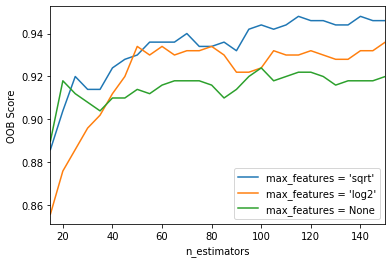

In [7]:
min_estimators = 15
max_estimators = 150

oob_scores = [[], [], []]

for ind, label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)
        oob_scores[ind].append((i, clf.oob_score_))

for i in range(len(ensemble_clfs)):
    xs, ys = zip(*oob_scores[i])
    plt.plot(xs, ys, label=ensemble_clfs[i][1])

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB Score")
plt.legend(loc="best")

### [예제 7.2] 랜덤 포레스트 분류 모델의 피처 중요도

In [8]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_classes=2,
                           random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [9]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [10]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
print(f'MDI 기반 피처 중요도 산출 소요 시간:{time.time() - start_time: .3f}초')

MDI 기반 피처 중요도 산출 소요 시간: 0.035초


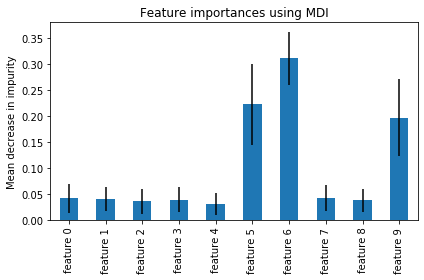

In [11]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [12]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(forest,
                                X_test,
                                y_test,
                                n_repeats=10,
                                random_state=0)
print(f'퍼뮤테이션 기반 피처 중요도 산출 소요 시간:{time.time() - start_time: .3f}초')

forest_importances = pd.Series(result.importances_mean, index=feature_names)

퍼뮤테이션 기반 피처 중요도 산출 소요 시간: 2.488초


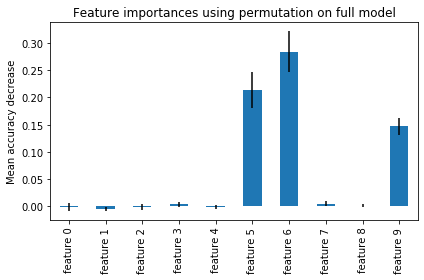

In [13]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title('Feature importances using permutation on full model')
ax.set_ylabel('Mean accuracy decrease')
fig.tight_layout()
plt.show()

## 07 되새김 문제

### [되새김 문제 7.1] RandomForestClassifier 클래스 적용하기

#### 문제

In [14]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1234)

#### 풀이

In [15]:
clf = RandomForestClassifier(random_state=1234,
                             n_estimators=50,
                             criterion='gini',
                             max_depth=4,
                             max_features='log2')

y_pred = clf.fit(X_train, y_train).predict(X_test)
print(f'정확도:{(y_pred == y_test).mean() * 100: .2f}%')

정확도: 98.00%


### [되새김 문제 7.2] 랜덤 포레스트 회귀 모델 구현하기

#### 문제

In [16]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=1234)
train = pd.concat([X_train, y_train], axis=1)
X_cols, y_col = X.columns.tolist(), y.name

#### 풀이

In [17]:
max_depth = 3
min_samples_split = 4

In [18]:
def eval_mse(left, right, y_col):
    mse, n1, n2 = 0, len(left), len(right)
    score = ((left[y_col] - left[y_col].mean())**2).mean()
    mse += score * n1 / (n1 + n2)
    score = ((right[y_col] - right[y_col].mean())**2).mean()
    mse += score * n2 / (n1 + n2)    
    return mse

def eval_y(df, y_col): 
    return df[y_col].mean()

def base_tree(train, X_cols, y_col, max_depth=4, min_samples_split=4):
    tree = []
    for i in range(0, 2**(max_depth + 1)):
        tree.append(dict({'struct': None}))
    tree[1]['struct'] = train
    for i in range(1, len(tree)):
        if not isinstance(tree[i]['struct'], pd.DataFrame): continue
        if i >= 2**max_depth:
            tree[i]['struct'] = eval_y(tree[i]['struct'], y_col)
            continue

        data = tree[i]['struct']
        a, b, c, d, e = '', float('inf'), float('inf'), None, None
        for X_col in X_cols: 
            vals = np.sort(data[X_col].unique())
            for val in vals[1:]:
                left, right = data[data[X_col] < val], data[data[X_col] >= val]
                mse = eval_mse(left, right, y_col)
                if mse < c: a, b, c, d, e = X_col, val, mse, left, right
        tree[i]['col'] = a
        tree[i]['val'] = b
        if len(d) >= min_samples_split: tree[i << 1]['struct'] = d
        else: tree[i << 1]['struct'] = eval_y(e, y_col)

        if len(e) >= min_samples_split: tree[(i << 1) + 1]['struct'] = e
        else: tree[(i << 1) + 1]['struct'] = eval_y(e, y_col)
    return tree

In [19]:
max_samples = 0.3
forest = []

for i in range(5):
    train0 = train.sample(frac=max_samples, random_state=123)
    forest.append(base_tree(train0, X_cols, y_col))

In [20]:
mae = 0
for i in range(len(X_test)):
    row = X_test.iloc[i]
    y_pred = 0
    for tree in forest:
        ind = 1
        node = tree[ind]
        while isinstance(node['struct'], pd.DataFrame):
            if row[node['col']] < node['val']: ind = ind << 1
            else: ind = (ind << 1) + 1
            
            node = tree[ind]
        y_pred += node['struct']

    y_pred = y_pred / len(forest)
    mae += np.abs(y_pred - y_test.iloc[i])
    
print(f'테스트 데이터셋 기준 MAE:{mae / len(y_test): .2f}')

테스트 데이터셋 기준 MAE: 46.28


In [21]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=5,
                            random_state=1234,
                            max_depth=3,
                            min_samples_split=4)
y_pred = reg.fit(X_train, y_train).predict(X_test)
print(f'RandomForestRegressor로 학습한 모델의 테스트 데이터셋 기준 MAE:{(np.abs(y_pred - y_test)).mean(): .2f}')

RandomForestRegressor로 학습한 모델의 테스트 데이터셋 기준 MAE: 45.39


### [되새김 문제 7.3] 퍼뮤테이션 기반 피처 중요도 계산하기

#### 문제

In [22]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

diabetes = load_diabetes(as_frame=True)
X_train, X_val, y_train, y_val = train_test_split(diabetes.data,
                                                  diabetes.target,
                                                  random_state=0)

#### 풀이

In [23]:
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance

model = Ridge(alpha=1e-2).fit(X_train, y_train)

pi = permutation_importance(model,
                            X_val,
                            y_val,
                            n_repeats=30,
                            random_state=0,
                            scoring='neg_mean_squared_error')

pi_series = pd.Series(pi.importances_mean, index=X_train.columns)
print(f'퍼뮤테이션 기반 피처별 중요도: {pi_series.sort_values(ascending=False).values[:3]}')

퍼뮤테이션 기반 피처별 중요도: [1013.90265117  872.69427744  438.68103665]
